# Adding Work Location to individuals

Assigning individuals to work locations

We follow the steps outlined in this [github issue](https://github.com/Urban-Analytics-Technology-Platform/acbm/issues/12)

In [2]:
import logging
import pickle as pkl
import random

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point

from acbm.assigning.assigning import (
    fill_missing_zones,
    filter_matrix_to_boundary,
    get_activities_per_zone,
    get_possible_zones,
    intrazone_time,
    replace_intrazonal_travel_time,
    select_activity,
    select_zone,
    zones_to_time_matrix,
)
from acbm.assigning.work import WorkZoneAssignment

# to display aall columns
pd.set_option('display.max_columns', None)




## Load in the data


### Activity chains

In [3]:
# read parquet file
activity_chains = pd.read_parquet('../data/interim/matching/spc_with_nts_trips.parquet')
activity_chains.head(10)

,id,household,location,pid_hs,msoa,oa,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,index_right,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,JourSeq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,MainMode_B04ID,TripPurpFrom_B01ID,TripPurpTo_B01ID,TripPurpose_B04ID,TripStart,TripEnd,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,TripOrigGOR_B02ID,TripDestGOR_B02ID,W5,W5xHH
0,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,16777.279297,8.72,E02002330_0029,1.0,NaN,6.0,True,1.0,2,1,60,1,2.0,55630,24067.22998,1,1,2,0,0,0,0,1,1,5,E00059012,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001902.0, 2019004101.0, 2019004092.0, 201...",9,2021007034,2.021064e+09,2.021046e+09,2.021007e+09,2.021003e+09,2.021000e+09,1.0,1.0,1.0,2.0,1.0,5.0,3.0,23.0,1.0,1.0,330.0,345.0,10.0,10.0,15.0,15.0,8.0,8.0,0.680422,1.000000
1,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,16777.279297,8.72,E02002330_0029,1.0,NaN,6.0,True,1.0,2,1,60,1,2.0,55630,24067.22998,1,1,2,0,0,0,0,1,1,5,E00059012,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001902.0, 2019004101.0, 2019004092.0, 201...",9,2021007034,2.021064e+09,2.021046e+09,2.021007e+09,2.021003e+09,2.021000e+09,1.0,1.0,2.0,2.0,1.0,5.0,3.0,1.0,23.0,1.0,885.0,900.0,10.0,10.0,15.0,15.0,8.0,8.0,0.680422,1.000000
2,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,16777.279297,8.72,E02002330_0029,1.0,NaN,6.0,True,1.0,2,1,60,1,2.0,55630,24067.22998,1,1,2,0,0,0,0,1,1,5,E00059012,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001902.0, 2019004101.0, 2019004092.0, 201...",9,2021007034,2.021064e+09,2.021046e+09,2.021007e+09,2.021003e+09,2.021000e+09,1.0,2.0,1.0,2.0,1.0,5.0,3.0,23.0,1.0,1.0,330.0,345.0,10.0,10.0,15.0,15.0,8.0,8.0,0.727735,1.069535
3,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,16777.279297,8.72,E02002330_0029,1.0,NaN,6.0,True,1.0,2,1,60,1,2.0,55630,24067.22998,1,1,2,0,0,0,0,1,1,5,E00059012,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001902.0, 2019004101.0, 2019004092.0, 201...",9,2021007034,2.021064e+09,2.021046e+09,2.021007e+09,2.021003e+09,2.021000e+09,1.0,2.0,2.0,2.0,1.0,5.0,3.0,1.0,23.0,1.0,795.0,810.0,10.0,10.0,15.0,15.0,8.0,8.0,0.727735,1.069535
4,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,16777.279297,8.72,E02002330_0029,1.0,NaN,6.0,True,1.0,2,1,60,1,2.0,55630,24067.22998,1,1,2,0,0,0,0,1,1,5,E00059012,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001902.0, 2019004101.0, 2019004092.0, 201...",9,2021007034,2.021064e+09,2.021046e+09,2.021007e+09,2.021003e+09,2.021000e+09,1.0,3.0,1.0,2.0,1.0,3.0,2.0,23.0,15.0,7.0,480.0,540.0,10.0,10.0,60.0,60.0,8.0,8.0,0.758707,1.115053
5,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,16777.279297,8.72,E02002330_0029,1.0,NaN,6.0,True,1.0,2,1,60,1,2.0,55630,24067.22998,1,1,2,0,0,0,0,1,1,5,E00059012,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001902.0, 2019004101.0, 2019004092.0, 201...",9,2021007034,2.021064e+09,2.021046e+09,2.021007e+09,2.021003e+09,2.021000e+09,1.0,3.0,2.0,2.0,1.0,3.0,2.0,15.0,23.0,7.0,540.0,600.0,10.0,10.0,60

#### Data preparation: Mapping trip purposes

Rename columns and map actual modes and trip purposes to the trip table. 

Code taken from: https://github.com/arup-group/pam/blob/main/examples/07_travel_survey_to_matsim.ipynb

In [4]:
activity_chains = activity_chains.rename(
    columns={  # rename data
        "JourSeq": "seq",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
    }
)

Check the NTS glossary [here](https://www.gov.uk/government/statistics/national-travel-survey-2022-technical-report/national-travel-survey-2022-technical-report-glossary) to understand what the trip purposes mean.

add an escort column

In [5]:
mode_mapping = {
    1: "walk",
    2: "cycle",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "car",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "car",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop_food",  #'Food shopping',
    5: "shop_other",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other_eat_drink",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other_eat_drink",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other_social",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other_sport",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort_home",  #'Escort home',
    18: "escort_work",  #'Escort work',
    19: "escort_work",  #'Escort in course of work',
    20: "escort_education",  #'Escort education',
    21: "escort_shopping",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}


activity_chains["mode"] = activity_chains["mode"].map(mode_mapping)

activity_chains["oact"] = activity_chains["oact"].map(purp_mapping)

activity_chains["dact"] = activity_chains["dact"].map(purp_mapping)

### Study area boundaries

In [9]:
boundaries = gpd.read_file('../data/external/boundaries/oa_england.geojson')
boundaries.head(10)

,OBJECTID,OA21CD,GlobalID,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LEP22CD1,LEP22NM1,LAD22CD,LAD22NM,rgn22cd,rgn22nm,ctry22cd,ctry22nm,geometry
0,1,E00000001,bc5eb21b-d42b-4715-a771-2c27575a08f0,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532303.492 181814.110, 532213...."
1,2,E00000003,a1a2b34f-320e-4bb8-acb4-7ca7ca16ef9c,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532213.378 181846.192, 532190...."
2,3,E00000005,9337da1a-fe0f-4210-9c95-ed2d20fd6287,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532180.131 181763.020, 532219...."
3,4,E00000007,b336e11f-af26-48a6-ac67-44f5b8b8840a,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532201.292 181668.180, 532267...."
4,5,E00000010,ca8f9874-cdf5-4c1a-9d39-f74a410dae44,E01000003,City of London 001C,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532127.958 182133.192, 532089...."
5,6,E00000013,b9b93246-bbfb-46af-8011-6b8ed5908956,E01000003,City of London 001C,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532247.654 181897.577, 532248...."
6,7,E00000018,fcb7c232-4165-44da-8ff8-b6cc383b528a,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532440.197 181842.934, 532544...."
7,8,E00000019,715e0851-2375-4d6a-94ac-532ba0833c60,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532619.141 181847.188, 532603...."
8,9,E00000020,4251a2ff-8fbe-4c11-aece-044f23ab9af2,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532515.000 181686.981, 532544...."
9,10,E00000021,48b2df49-45ed-48a4-b7fc-e0e32c1ad088,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532746.813 181786.891, 532671...."


In [10]:
# filter to only include the OA's where "Leeds" is in the MSOA21NM field
boundaries = boundaries[boundaries['MSOA21NM'].str.contains("Leeds", na=False)]

In [ ]:
# convert boundaries to 4326
boundaries = boundaries.to_crs(epsg=4326)
# plot the geometry
boundaries.plot()

In [ ]:
boundaries.head(5)

#### Assign activity home locations to boundaries zoning system 

Convert location column in activity_chains to spatial column

In [ ]:
# turn column to shapely point
activity_chains['location'] = activity_chains['location'].apply(lambda loc: Point(loc['x'], loc['y']))

# Convert the DataFrame into a GeoDataFrame, and assign a coordinate reference system (CRS)
activity_chains = gpd.GeoDataFrame(activity_chains, geometry='location')
activity_chains.crs = "EPSG:4326" # I assume this is the crs


In [ ]:
# plot the boundaries gdf and overlay them with the activity_chains gdf
fig, ax = plt.subplots(figsize=(10, 8))
boundaries.plot(ax=ax, color='lightgrey')
activity_chains.plot(ax=ax, color='red', markersize=1)
plt.title('Activity Chains overlaid on Leeds Output Areas')
plt.show()


In [ ]:
#remove index_right column from activity_chains if it exists
if 'index_right' in activity_chains.columns:
    activity_chains = activity_chains.drop(columns='index_right')


# Spatial join to identify which polygons each point is in
activity_chains = gpd.sjoin(activity_chains, boundaries[["OA21CD", "geometry"]], how='left', predicate='within')
activity_chains = activity_chains.drop('index_right', axis=1)


### Travel time matrix for study area

Travel time data between geographical areas (LSOA, OA, custom hexagons etc) is used to determine feasible work / school locations for each individual. The travel times are compared to the travel times of the individual's actual trips from the nts (`tst`/`TripStart` and `tet`/`TripEnd`)

In [ ]:
travel_times = pd.read_parquet('../data/external/travel_times/oa/travel_time_matrix_acbm.parquet')
travel_times.head(10)

In [ ]:
travel_times["combination"].unique()

Add area code to travel time data

In [ ]:
# convert from_id and to_id to int to match the boundaries data type
travel_times = travel_times.astype({'from_id': int, 'to_id': int})

# merge travel_times with boundaries
travel_times = travel_times.merge(boundaries[['OBJECTID', 'OA21CD']], left_on='from_id', right_on='OBJECTID', how='left')
travel_times = travel_times.drop(columns='OBJECTID')

travel_times = travel_times.merge(boundaries[['OBJECTID', 'OA21CD']], left_on='to_id', right_on='OBJECTID', how='left', suffixes=('_from', '_to'))
travel_times = travel_times.drop(columns='OBJECTID')

travel_times.head(10)

#### Travel distance matrix

Some areas aren't reachable by specific modes. This can cause problems later on in get_possible_zones() as we won't be able to assign some activities to zones. We create a travel distance matrix to fall back on when there are no travel time calculations

In [ ]:
travel_time_estimates = zones_to_time_matrix(
    zones = boundaries,
    id_col = "OA21CD",
    to_dict = True
)

What does the data look like?

In [ ]:
# Get an iterator over the dictionary items and then print the first n items
items = iter(travel_time_estimates.items())

for i in range(5):
    print(next(items))

In [ ]:
with open('../data/interim/assigning/travel_time_estimates.pkl', 'wb') as f:
    pkl.dump(travel_time_estimates, f)

#### Intrazonal trip times 

Intrazonal trips all have time = 0. Our `get_possible_zones` function finds zones that are within a specified % threshold from the reported time in the NTS. A threshold percentage from a non zero number never equals 0, so intrazonal trips are not found. The problem is also explained in this [github issue](https://github.com/Urban-Analytics-Technology-Platform/acbm/issues/30)

Below, we assign intrazonal trips a non-zero time based on the zone area

In [ ]:
# get intrazone travel time estimates per mode

intrazone_times = intrazone_time(boundaries)

# print first 10 items in the dictionary
items = iter(intrazone_times.items())

for i in range(10):
    print(next(items))

In [ ]:
# replace intrazonal travel times with estimates from intrazone_times

travel_times = replace_intrazonal_travel_time(travel_times= travel_times,
                                              intrazonal_estimates= intrazone_times,
                                              column_to_replace= 'travel_time_p50')



### Activity locations 

Activity locations are obtained from OSM using the [osmox](https://github.com/arup-group/osmox) package. Check the config documentation in the package and the `config_osmox` file in this repo

In [ ]:
# osm data
osm_data = gpd.read_parquet('../data/external/boundaries/west-yorkshire_epsg_4326.parquet')

In [ ]:
osm_data.head(10)

In [ ]:
# get unique values for activties column
osm_data['activities'].unique()

In [ ]:
# remove rows with activities = home OR transit

osm_data = osm_data[~osm_data['activities'].isin(['home', 'transit'])]
#osm_data = osm_data[osm_data['activities'] != 'home']
osm_data.head(10)


In [ ]:
osm_data.activities.unique()

#### Get the number of activities in each zone 

Each zone has a different number of education facilities. We can use the number of facilities in each zone to determine the probability of each zone being chosen for each trip. We can then use these probabilities to randomly assign a zone to each trip.

The education facilities are disaggregated by type. For each activity, we use the individual's age to detemrine which of the following they are most likely to go to 

- "kindergarden": education_kg"
- "school": "education_school"
- "university": "education_university"
- "college": "education_college"

In [ ]:
# spatial join to identify which zone each point in osm_data is in
osm_data_gdf = gpd.sjoin(osm_data, boundaries[["OA21CD", "geometry"]], how='inner', predicate='within')
osm_data_gdf.head(5)

In [ ]:
# plot the points and then plot the zones on a map
fig, ax = plt.subplots(figsize=(10, 8))
boundaries.plot(ax=ax, color='lightgrey')
osm_data_gdf.plot(ax=ax, color='red', markersize=1)
plt.title('OSM Data overlaid on Leeds Output Areas')
plt.show()

To select a zone from a list of zones, we need a list of the activity types that are available in the zone. We then sample probabilistically based on number of activities / total floorspace

`get_activities_per_zone()` can return a dictionary of dfs, or one big df. Just set `return_df` to `True` to get one df. Let's try both

In [ ]:
activities_per_zone_dict = get_activities_per_zone(
    zones = boundaries,
    zone_id_col = "OA21CD",
    activity_pts = osm_data,
    )

What does the data look like?

In [ ]:
# Get an iterator over the dictionary items
items = iter(activities_per_zone_dict.items())

# Print the first 5 items
for i in range(5):
    print(next(items))

In [ ]:
activities_per_zone = get_activities_per_zone(
    zones = boundaries,
    zone_id_col = "OA21CD",
    activity_pts = osm_data,
    return_df = True
    )

activities_per_zone

In [ ]:
with open('../data/interim/assigning/activities_per_zone.pkl', 'wb') as f:
    pkl.dump(activities_per_zone_dict, f)

# save activities_per_zone as a parquet file
activities_per_zone.to_parquet('../data/interim/assigning/activities_per_zone.parquet')

### Commuting matrices (from 2021 census)

In [7]:
commute_level = "OA"  # "OA" or "MSOA" data

Clean the data 

In [11]:
if commute_level == "MSOA":
    print("Step 1: Reading in the zipped csv file")
    travel_demand = pd.read_csv('../data/external/ODWP15EW_MSOA_v1.zip')

    print("Step 2: Creating commute_mode_dict")
    commute_mode_dict = {
        "Bus, minibus or coach": "pt",
        "Driving a car or van": "car",
        "Train": "pt",
        "Underground, metro, light rail, tram": "pt",
        "On foot": "walk",
        "Taxi": "car",
        "Other method of travel to work": "other",
        "Bicycle": "cycle",
        "Passenger in a car or van": "car",
        "Motorcycle, scooter or moped": "car",
        "Work mainly at or from home": "home"
    }

    print("Step 3: Mapping commute mode to model mode")
    travel_demand['mode'] = travel_demand['Method used to travel to workplace (12 categories) label'].map(commute_mode_dict)

    print("Step 4: Filtering rows and dropping unnecessary columns")
    travel_demand_clipped = travel_demand[travel_demand['Place of work indicator (4 categories) code'].isin([1, 3])]
    travel_demand_clipped = travel_demand_clipped.drop(columns=['Middle layer Super Output Areas label', 'MSOA of workplace label',
                                                                    'Method used to travel to workplace (12 categories) label', 'Method used to travel to workplace (12 categories) code',
                                                                    'Place of work indicator (4 categories) code', 'Place of work indicator (4 categories) label'])

    print("Step 5: Renaming columns and grouping")
    travel_demand_clipped = travel_demand_clipped.rename(columns={'Middle layer Super Output Areas code': 'MSOA21CD_home',
                                                                        'MSOA of workplace code': 'MSOA21CD_work'})
    travel_demand_clipped = travel_demand_clipped.groupby(['MSOA21CD_home', 'MSOA21CD_work', 'mode']).agg({'Count': 'sum'}).reset_index()

    print("Step 6: Filtering matrix to boundary")
    travel_demand_clipped = filter_matrix_to_boundary(
        boundary = boundaries,
        matrix = travel_demand_clipped,
        boundary_id_col = "MSOA21CD",
        matrix_id_col = "MSOA21CD",
        type = "both"
    )

elif commute_level == "OA":
    print("Step 1: Reading in the zipped csv file")
    travel_demand = pd.read_csv('../data/external/ODWP01EW_OA.zip')

    print("Step 2: Filtering rows and dropping unnecessary columns")
    travel_demand_clipped = travel_demand[travel_demand['Place of work indicator (4 categories) code'].isin([1, 3])]
    travel_demand_clipped = travel_demand_clipped.drop(columns=['Place of work indicator (4 categories) code', 'Place of work indicator (4 categories) label'])

    print("Step 3: Renaming columns and grouping")
    travel_demand_clipped = travel_demand_clipped.rename(columns={'Output Areas code': 'OA21CD_home',
                                                                        'OA of workplace code': 'OA21CD_work'})
    travel_demand_clipped = travel_demand_clipped.groupby(['OA21CD_home', 'OA21CD_work']).agg({'Count': 'sum'}).reset_index()

    print("Step 4: Filtering matrix to boundary")
    travel_demand_clipped = filter_matrix_to_boundary(
        boundary = boundaries,
        matrix = travel_demand_clipped,
        boundary_id_col = "OA21CD",
        matrix_id_col = "OA21CD",
        type = "both"
    )

Step 1: Reading in the zipped csv file
Step 2: Filtering rows and dropping unnecessary columns
Step 3: Renaming columns and grouping
Step 4: Filtering matrix to boundary


In [ ]:
travel_demand_clipped.head(10)

Get dictionary of commuting matrices

In [12]:
if commute_level == "MSOA":
    travel_demand_dict_mode = travel_demand_clipped.groupby(['MSOA21CD_home', 'MSOA21CD_work']).apply(
        lambda x: dict(zip(x['mode'], x['Count']))).to_dict()
    travel_demand_dict_nomode = travel_demand_clipped.groupby(['MSOA21CD_home', 'MSOA21CD_work'])['Count'].sum().to_dict()

elif commute_level == "OA":
    travel_demand_dict_nomode = travel_demand_clipped.groupby(['OA21CD_home', 'OA21CD_work'])['Count'].sum().to_dict()




In [ ]:
# Get an iterator over the dictionary items
items = iter(travel_demand_dict_nomode.items())

# Print the first 5 items
for i in range(5):
    print(next(items))


### Business Registry

In [ ]:
business_registry = pd.read_csv('../data/external/businessRegistry.csv.gz')

business_registry.head(5)

In [ ]:
# Match 2011 MSOA codes to 2021 MSOA codes

msoa_lookup = pd.read_csv('../data/external/MSOA_2011_MSOA_2021_Lookup_for_England_and_Wales.csv')

# match MSOA21CD to businessregistry MSOA11CD
business_registry = business_registry.merge(msoa_lookup[['MSOA11CD', 'MSOA21CD']],
                                            left_on='MSOA11CD',
                                            right_on='MSOA11CD', how='left')

business_registry

In [ ]:
# filter Business Registry to only include rows where MSOA21CD is in boundaries
business_registry = business_registry[business_registry['MSOA21CD'].isin(boundaries['MSOA21CD'])]

Let's visualise the spatial distribution of businesses in the study area

In [ ]:
# Group by 'MSOA21CD' and 'SIC1d07' and get number of rows in each group

#business_registry_vis = business_registry.groupby(['MSOA21CD', 'sic1d07']).size().reset_index(name='count')
business_registry_vis = business_registry.groupby(['MSOA21CD', 'sic1d07'])['size'].sum().reset_index(name='count')
# add spatial information to business_registry
business_registry_vis = business_registry_vis.merge(boundaries[['MSOA21CD', 'geometry']], on='MSOA21CD', how='left')

business_registry_vis.head(5)

In [ ]:
import matplotlib.colors as mcolors

# Ensure business_registry_vis is a GeoDataFrame
business_registry_vis = gpd.GeoDataFrame(business_registry_vis)

# Boundary layer for background
outer_boundary = boundaries.unary_union

# Get unique 'sic1d07' ids
sic1d07_ids = np.sort(business_registry_vis['sic1d07'].astype(int).unique())

# Calculate the number of rows needed for the subplots
n_rows = int(np.ceil(len(sic1d07_ids) / 3))

# Create a grid of subplots
fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows*5))

# Flatten the array of axes
axs = axs.flatten()

# Calculate global min and max counts (so that all maps have the same legend scale)
vmin = business_registry_vis['count'].min()
vmax = business_registry_vis['count'].max()


# Create a separate map for each 'sic1d07' id
for i, sic1d07_id in enumerate(sic1d07_ids):
    # Subset the data for the current 'sic1d07' id
    data_subset = business_registry_vis[business_registry_vis['sic1d07'] == sic1d07_id]

    # Plot the boundary layer on the current subplot
    gpd.GeoSeries(outer_boundary).plot(ax=axs[i], color='none', edgecolor='#d3d3d3')

    # Create the map on the current subplot
    data_subset.plot(column='count', legend=True, cmap='viridis', ax=axs[i],
                     norm=mcolors.LogNorm(vmin=vmin, vmax=vmax))

    # Set the title
    axs[i].set_title(f'sic1d07 id: {sic1d07_id}')

# Remove empty subplots
for i in range(len(sic1d07_ids), len(axs)):
    fig.delaxes(axs[i])

# Add a main title
fig.suptitle('Spatial distribution of jobs by SIC category', fontsize=18, y=0.9)

# Adjust the layout to leave space for the main title
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Show the plot
plt.show()


In [ ]:
sic1d07_ids = business_registry_vis['sic1d07'].unique()

sic1d07_ids

In [ ]:
# add spatial information to business_registry
business_registry_map = business_registry.merge(boundaries[['MSOA21CD', 'geometry']], on='MSOA21CD', how='left')



#### Match sic codes between registry and activity chains

The sic codes in the business registry are numeric. From the [documentation](https://alan-turing-institute.github.io/uatk-spc/understanding_data_sources.html#businessregistry.csv.gz): ` (number corresponding to the letter in alphabetical order)` 

We need to convert the SIC codes in the activity_chains df to numeric

In [ ]:
business_registry['sic1d07'].unique()

In [ ]:

# create a new column in activity_chains_work that converts sic1d2007 from letter to numeric

# ord() returns ascii value of a character. We get values relative to the value of A

activity_chains.loc[:, 'sic1d2007_num'] = activity_chains['sic1d2007'].apply(lambda x: ord(x) - ord('A') + 1 if x is not None else 0)
activity_chains.head(10)

In [ ]:
# Get the unique values in the 'sic1d2007_num' column
unique_values = np.unique(activity_chains['sic1d2007_num'])

# Create bins from the unique values
bins = np.append(unique_values, unique_values[-1] + 1)

# Create histogram
plt.hist(activity_chains[activity_chains['dact'] == 'work']['sic1d2007_num'], bins=bins, align='left')
# Set x-ticks
plt.xticks(unique_values)

plt.xlabel('SIC 2007 code')
plt.ylabel('Number of venues')
plt.title('Number of jobs in each SIC 2007 code')
plt.show()

## Workplace Assignment

The NTS gives us the trip duration, mode, and trip purpose of each activity. We have also calculated a zone to zone travel time matrix by mode. We know the locaiton of people's homes so, for home-based activities, we can use this information to determine the feasible zones for each activity.

- Determine activity origin zone, mode, and duration (these are the constraints)
- Filter travel time matrix to include only destinations that satisfy all constraints. These are the feasible zones
- If there are no feasible zones, select the zone with the closest travel time to the reported duration

### Getting feasible zones for each activity

In [13]:
activity_chains_work = activity_chains[activity_chains['dact'] == 'work']
# Let's focus on a specific day of the week
activity_chains_work = activity_chains_work[activity_chains_work['TravDay'] == 3] # Wednesday


activity_chains_work.head(5)

,id,household,location,pid_hs,msoa,oa,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,index_right,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH
164,1193224,479418,"{'x': -1.3888310194015503, 'y': 53.93902969360...",2906516,E02002330,E00059011,"[1193224, 1193225]",C,25.0,6,NaN,NaN,E02002330_0109,1.0,NaN,6.0,True,1.0,1,1,71,1,4.0,55629,0.00000,1,1,1,0,1,1,1,0,0,1,E00059011,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,[2021004187.0],9,2021009590,2.021092e+09,2.021062e+09,2.021010e+09,2.021004e+09,2.021001e+09,1.0,3.0,2.0,2.0,1.0,5.0,car,shop_food,work,6.0,690.0,710.0,9.7,9.7,20.0,20.0,2.0,2.0,0.836477,1.138030
204,1193282,479443,"{'x': -1.3983349800109863, 'y': 53.93864059448...",2904707,E02002330,E00059027,"[1193280, 1193281, 1193282]",None,NaN,8,NaN,NaN,E02002330_0134,3.0,NaN,6.0,True,2.0,1,2,16,1,NaN,55645,0.00000,1,1,3,0,0,0,0,0,0,1,E00059027,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019000571.0, 2019003239.0, 2019000891.0, 201...",3,2019001210,2.019017e+09,2.019008e+09,2.019001e+09,2.019001e+09,2.019000e+09,1.0,3.0,1.0,2.0,1.0,5.0,car,home,work,1.0,415.0,419.0,3.0,3.0,4.0,4.0,7.0,7.0,1.249810,1.007174
222,1193351,479481,"{'x': -1.4078869819641113, 'y': 53.93016052246...",2910567,E02002330,E00059039,"[1193351, 1193352, 1193353]",C,27.0,1,83669.34375,32.180515,E02002330_0172,1.0,NaN,6.0,True,2.0,2,1,42,1,1.0,55657,83669.34375,3,1,2,0,1,0,0,1,0,3,E00059039,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,2019011223,2.019147e+09,2.019071e+09,2.019011e+09,2.019005e+09,2.019001e+09,1.0,3.0,1.0,2.0,1.0,5.0,car,home,work,1.0,390.0,410.0,9.2,9.2,20.0,20.0,9.0,9.0,0.967428,1.007174
227,1193352,479481,"{'x': -1.4078869819641113, 'y': 53.93016052246...",2900880,E02002330,E00059039,"[1193351, 1193352, 1193353]",None,NaN,8,NaN,NaN,E02002330_0172,1.0,NaN,6.0,True,2.0,2,2,41,1,NaN,55657,83669.34375,3,1,2,0,1,0,0,1,0,3,E00059039,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,2019011224,2.019147e+09,2.019071e+09,2.019011e+09,2.019005e+09,2.019001e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,work,work,2.0,840.0,870.0,15.0,15.0,30.0,30.0,8.0,9.0,0.960537,1.000000
250,1193352,479481,"{'x': -1.4078869819641113, 'y': 53.93016052246...",2900880,E02002330,E00059039,"[1193351, 1193352, 1193353]",None,NaN,8,NaN,NaN,E02002330_0172,1.0,NaN,6.0,True,2.0,2,2,41,1,NaN,55657,83669.34375,3,1,2,0,1,0,0,1,0,3,E00059039,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,2019011224,2.019147e+09,2.019071e+09,2.019011e+09,2.019005e+09,2.019001e+09,2.0,3.0,2.0,2.0,1.0,5.0,car,escort_education,work,2.0,490.0,515.0,10.0,10.0,25.0,25.0,9.0,9.0,0.960537,1.000000


In [ ]:
possible_zones_work = get_possible_zones(activity_chains=activity_chains_work,
                                         travel_times=travel_times,
                                         activities_per_zone = activities_per_zone,
                                         filter_by_activity=True,
                                         activity_col= "dact",
                                         time_tolerance=0.2)


In [ ]:
possible_zones_work

In [ ]:
# Output is a nested dictionary
for key in list(possible_zones_work.keys())[:10]:
    print(key, ' : ', possible_zones_work[key])

In [ ]:
# save possible_zones_school to dictionary
with open('../data/interim/assigning/possible_zones_work.pkl', 'wb') as f:
    pkl.dump(possible_zones_work, f)


In [14]:
# remove possible_zones_work from environment
#del possible_zones_work

# read in possible_zones_school
possible_zones_work = pd.read_pickle('../data/interim/assigning/possible_zones_work.pkl')


### Choose a zone for each activity

We choose a zone from the feasible zones. We have two options:

1) Iteratively loop over individuals and choose a zone from the feasible zones. We make sure that we don't exceed the flows reported in the commuting matrices

2) Set up the problem as a Maximum Flow Problem (Optimization)

In [16]:
zone_assignment = WorkZoneAssignment(
    activities_to_assign = possible_zones_work,
    actual_flows = travel_demand_dict_nomode
    )



#### Option 1: Iterative loop assignment with constraints

In [17]:
# Step 8: Perform the assignment
assignments_df = zone_assignment.select_work_zone_iterative(
    random_assignment=True)

In [21]:
assignments_df

# count number of weighted and random
# assignments_df['Assignment_Type'].value_counts()

,activity_id,origin_zone,assigned_zone,assignment_type
0,164,E00059011,E00059075,Weighted
1,204,E00059027,E00059014,Weighted
2,222,E00059039,E00057446,Random
3,227,E00059039,E00187152,Weighted
4,250,E00059039,E00059102,Weighted
...,...,...,...,...
3599,226899,E00058919,E00058951,Weighted
3600,227520,E00057643,E00169783,Weighted
3601,227781,E00057703,E00187047,Weighted
3602,231814,E00187028,E00170433,Weighted


In [ ]:
# count number of None values in Assigned_Zone column
assignments_df['assigned_zone'].isnull().sum()

In [ ]:
# Convert travel_demand_dict_nomode to a DataFrame
travel_demand_df = pd.DataFrame(list(travel_demand_dict_nomode.items()), columns=['OD_Pair', 'Flow'])

# Split the OD_Pair into two separate columns
travel_demand_df[['Origin', 'Destination']] = pd.DataFrame(travel_demand_df['OD_Pair'].tolist(), index=travel_demand_df.index)

# Drop the OD_Pair column
travel_demand_df = travel_demand_df.drop('OD_Pair', axis=1)

# Count the number of times each OD pair occurs in assignments_df
assignments_counts = assignments_df.groupby(['origin_zone', 'assigned_zone']).size().reset_index(name='Count')

# Compare the two DataFrames
comparison_df = pd.merge(travel_demand_df, assignments_counts, how='outer', left_on=['Origin', 'Destination'], right_on=['origin_zone', 'assigned_zone'])


# # arrange comparisons_df in descending order of Count

# #comparison_df = comparison_df.sort_values(by=['Origin', 'Count'], ascending=[True, False])
# comparison_df = comparison_df.sort_values(by='Count', ascending= False)

# comparison_df.head(20)

# Sum the 'Count' for each 'Origin'
origin_counts = comparison_df.groupby('Origin')['Count'].sum().reset_index(name='Total_Count')

# Merge the new DataFrame with the original DataFrame
comparison_df = pd.merge(comparison_df, origin_counts, on='Origin')

# Sort by 'Total_Count' in descending order
comparison_df = comparison_df.sort_values(by='Total_Count', ascending=False)

comparison_df.head(100)

In [ ]:
# group assignments_df by 'Home_Zone' and 'Assigned_Zone' and count the number of rows in each group
assignments_df.groupby(['origin_zone', 'assigned_zone']).size().reset_index(name='count').sort_values(by='count', ascending=False)

# compare to travel_demand_dict_nomode




Compare to actual flows

In [ ]:
# Step 1: Convert the dictionary to a DataFrame
travel_demand_df = {'origin': [k[0] for k in travel_demand_dict_nomode.keys()],
                    'destination': [k[1] for k in travel_demand_dict_nomode.keys()],
                    'demand': list(travel_demand_dict_nomode.values())}
travel_demand_df = pd.DataFrame(travel_demand_df)

# Step 2: Me

#### Option 2: Optimization Problem 

In [19]:
assignment_opt = zone_assignment.select_work_zone_optimization(
    use_percentages=True,
    weight_max_dev=0.8,
    weight_total_dev=0.2)

print(assignment_opt)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5d84393364ab41c68c82cdb7568e9ae6-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/5d84393364ab41c68c82cdb7568e9ae6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 327860 COLUMNS
At line 993267 RHS
At line 1321123 BOUNDS
At line 1345873 ENDATA
Problem MODEL has 327855 rows, 133082 columns and 507575 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 517.336 - 2.12 seconds
Cgl0004I processed model has 43826 rows, 43290 columns (24102 integer (24081 of which binary)) and 116355 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 2.14797e-11
Cbc0038I Solution found of 517.336
Cbc0038I Relaxing continuous gives 517.336
Cbc0038I Cleaned sol

In [22]:
assignment_opt

,person_id,home_zone,assigned_zone
0,164,E00059011,E00058794
1,204,E00059027,E00059014
2,227,E00059039,E00058199
3,250,E00059039,E00059102
4,542,E00059015,E00057544
...,...,...,...
2854,226899,E00058919,E00058897
2855,227520,E00057643,E00187137
2856,227781,E00057703,E00187047
2857,231814,E00187028,E00170433


In [23]:
travel_demand_dict_nomode

{('E00056750', 'E00056750'): 56,
 ('E00056750', 'E00056752'): 2,
 ('E00056750', 'E00056753'): 8,
 ('E00056750', 'E00056766'): 2,
 ('E00056750', 'E00056784'): 1,
 ('E00056750', 'E00056788'): 1,
 ('E00056750', 'E00056796'): 1,
 ('E00056750', 'E00056815'): 3,
 ('E00056750', 'E00056823'): 1,
 ('E00056750', 'E00056835'): 1,
 ('E00056750', 'E00057050'): 1,
 ('E00056750', 'E00057068'): 1,
 ('E00056750', 'E00057134'): 1,
 ('E00056750', 'E00057212'): 1,
 ('E00056750', 'E00057226'): 1,
 ('E00056750', 'E00057245'): 1,
 ('E00056750', 'E00057315'): 1,
 ('E00056750', 'E00057362'): 1,
 ('E00056750', 'E00057403'): 1,
 ('E00056750', 'E00057529'): 2,
 ('E00056750', 'E00057695'): 1,
 ('E00056750', 'E00057759'): 1,
 ('E00056750', 'E00058207'): 1,
 ('E00056750', 'E00058309'): 1,
 ('E00056750', 'E00058317'): 1,
 ('E00056750', 'E00058332'): 2,
 ('E00056750', 'E00058345'): 2,
 ('E00056750', 'E00058347'): 2,
 ('E00056750', 'E00058352'): 3,
 ('E00056750', 'E00058371'): 2,
 ('E00056750', 'E00058384'): 1,
 ('E000

#### Evaluating assignment quality

##### RMSE

In [31]:

# Step 1: Convert both the actual demand and the assigned demand data to the correct format
# df: home_zone, assigned_zone, demand_assigned

# a: Aggregate assignment_opt DataFrame
assignment_agg = assignment_opt.groupby(['home_zone', 'assigned_zone']).size().reset_index(name='demand_assigned')

# b: Convert travel_demand_dict_no_mode to DataFrame
demand_df = pd.DataFrame(list(travel_demand_dict_nomode.items()), columns=['zone_pair', 'demand_actual'])
demand_df[['home_zone', 'assigned_zone']] = pd.DataFrame(demand_df['zone_pair'].tolist(), index=demand_df.index)
demand_df.drop(columns=['zone_pair'], inplace=True)


# Step 2: Merge the two DataFrames
workzone_assignment_opt = pd.merge(assignment_agg, demand_df, on=['home_zone', 'assigned_zone'], how='outer').fillna(0)
workzone_assignment_opt



,home_zone,assigned_zone,demand_assigned,demand_actual
0,E00056750,E00056750,0.0,56
1,E00056750,E00056752,0.0,2
2,E00056750,E00056753,0.0,8
3,E00056750,E00056766,0.0,2
4,E00056750,E00056784,0.0,1
...,...,...,...,...
108327,E00187153,E00187074,0.0,1
108328,E00187153,E00187120,0.0,1
108329,E00187153,E00187137,0.0,1
108330,E00187153,E00187152,0.0,11


In [34]:
# (1) % of Total Demand
workzone_assignment_opt['pct_of_total_demand_actual'] = (workzone_assignment_opt['demand_actual'] /  workzone_assignment_opt['demand_actual'].sum()) * 100
workzone_assignment_opt['pct_of_total_demand_assigned'] = (workzone_assignment_opt['demand_assigned'] / workzone_assignment_opt['demand_assigned'].sum()) * 100

# (2) For each OD pair, demand as % of total demand from the same origin
workzone_assignment_opt['pct_of_o_total_actual'] = workzone_assignment_opt.groupby('home_zone')['demand_actual'].transform(lambda x: (x / x.sum()) * 100)
workzone_assignment_opt['pct_of_o_total_assigned'] = workzone_assignment_opt.groupby('home_zone')['demand_assigned'].transform(lambda x: (x / x.sum()) * 100)

# (3) For each OD pair, demand as % of total demand to each destination
workzone_assignment_opt['pct_of_d_total_actual'] = workzone_assignment_opt.groupby('assigned_zone')['demand_actual'].transform(lambda x: (x / x.sum()) * 100)
workzone_assignment_opt['pct_of_d_total_assigned'] = workzone_assignment_opt.groupby('assigned_zone')['demand_assigned'].transform(lambda x: (x / x.sum()) * 100)

workzone_assignment_opt.head(20)

,home_zone,assigned_zone,demand_assigned,demand_actual,pct_of_total_demand_actual,pct_of_total_demand_assigned,pct_of_o_total_actual,pct_of_o_total_assigned,pct_of_d_total_actual,pct_of_d_total_assigned
0,E00056750,E00056750,0.0,56,0.017130,0.0,41.481481,NaN,98.245614,NaN
1,E00056750,E00056752,0.0,2,0.000612,0.0,1.481481,NaN,0.634921,0.0
2,E00056750,E00056753,0.0,8,0.002447,0.0,5.925926,NaN,1.612903,0.0
3,E00056750,E00056766,0.0,2,0.000612,0.0,1.481481,NaN,0.412371,0.0
4,E00056750,E00056784,0.0,1,0.000306,0.0,0.740741,NaN,0.813008,NaN
5,E00056750,E00056788,0.0,1,0.000306,0.0,0.740741,NaN,1.298701,0.0
6,E00056750,E00056796,0.0,1,0.000306,0.0,0.740741,NaN,1.923077,NaN
7,E00056750,E00056815,0.0,3,0.000918,0.0,2.222222,NaN,0.958466,0.0
8,E00056750,E00056823,0.0,1,0.000306,0.0,0.740741,NaN,0.854701,0.0
9,E00056750,E00056835,0.0,1,0.000306,0.0,0.740741,NaN,0.392157,0.0


In [38]:
from math import sqrt

from sklearn.metrics import mean_squared_error

# (1) RMSE for % of Total Demand
rmse_pct_of_total_demand = sqrt(mean_squared_error(
    workzone_assignment_opt['pct_of_total_demand_actual'],
    workzone_assignment_opt['pct_of_total_demand_assigned']))

# (2) RMSE for demand as % of total demand from the same origin
rmse_pct_of_o_total = sqrt(mean_squared_error(
    workzone_assignment_opt['pct_of_o_total_actual'],
    workzone_assignment_opt['pct_of_o_total_assigned']))

# (3) RMSE for demand as % of total demand to each destination
rmse_pct_of_d_total = sqrt(mean_squared_error(
    workzone_assignment_opt['pct_of_d_total_actual'],
    workzone_assignment_opt['pct_of_d_total_assigned']))

print(f"RMSE for % of Total Demand: {rmse_pct_of_total_demand}")
print(f"RMSE for % of Total Demand from the Same Origin: {rmse_pct_of_o_total}")
print(f"RMSE for % of Total Demand to Each Destination: {rmse_pct_of_d_total}")

ValueError: Input contains NaN.

##### Mapping the differences



$$q_{j} = (D_{j} - D_{j}^{obs}) / \sum_{i=1}^{k} D_{k} = (D{j} / \sum_{k} D_{k}) - (D{j}^{obs} / \sum_{k} D_{k}^{obs})$$ 

- $D_{j}$ is the number of trips going to zone $j$ in the synthetic data, and $D_{j}^{obs}$ is the number of trips going to zone $j$ in the observed data. 
- $D_{k}$ is the total number of trips in the synthetic data, and $D_{k}^{obs}$ is the total number of trips in the observed data.


In [72]:
total_actual = workzone_assignment_opt['demand_actual'].sum()
total_assigned = workzone_assignment_opt['demand_assigned'].sum()

# Calculate the total demand and total assigned demand for each destination zone
workzone_assignment_opt_agg = workzone_assignment_opt.groupby('assigned_zone').agg(
    total_demand_actual=('demand_actual', 'sum'),
    total_demand_assigned=('demand_assigned', 'sum')
).reset_index()

# Calculate qj (total_demand_actual / total_actual)
workzone_assignment_opt_agg['dj_actual_dk'] = workzone_assignment_opt_agg['total_demand_actual'] / total_actual
workzone_assignment_opt_agg['dj_assigned_dk'] = workzone_assignment_opt_agg['total_demand_assigned'] / total_assigned
workzone_assignment_opt_agg['qj'] = (workzone_assignment_opt_agg['dj_actual_dk'] - workzone_assignment_opt_agg['dj_assigned_dk']) * 100

# workzone_assignment_opt_agg['qj'] = (workzone_assignment_opt_agg['total_demand_actual'] / total_actual) - (workzone_assignment_opt_agg['total_demand_assigned'] / total_assigned)
workzone_assignment_opt_agg

,assigned_zone,total_demand_actual,total_demand_assigned,dj_actual_dk,dj_assigned_dk,qj
0,E00056750,57,0.0,0.000174,0.000000,0.017435
1,E00056751,97,1.0,0.000297,0.000350,-0.005306
2,E00056752,315,8.0,0.000964,0.002798,-0.183465
3,E00056753,496,14.0,0.001517,0.004897,-0.337963
4,E00056754,77,0.0,0.000236,0.000000,0.023553
...,...,...,...,...,...,...
2602,E00187149,353,3.0,0.001080,0.001049,0.003045
2603,E00187150,163,0.0,0.000499,0.000000,0.049859
2604,E00187151,52,0.0,0.000159,0.000000,0.015906
2605,E00187152,6193,84.0,0.018943,0.029381,-1.043749


In [73]:
total_actual, total_assigned

(326921, 2859.0)

In [74]:
# merge boundaries with workzone_assignment_opt
workzone_assignment_opt_agg_gdf = boundaries[['OA21CD', 'geometry']].merge(workzone_assignment_opt_agg, left_on='OA21CD', right_on='assigned_zone', how='left')

# Ensure the result is a GeoDataFrame
workzone_assignment_opt_agg_gdf = gpd.GeoDataFrame(workzone_assignment_opt_agg_gdf)
workzone_assignment_opt_agg_gdf

,OA21CD,geometry,assigned_zone,total_demand_actual,total_demand_assigned,dj_actual_dk,dj_assigned_dk,qj
0,E00056750,"MULTIPOLYGON (((420675.101 441465.476, 420653....",E00056750,57,0.0,0.000174,0.000000,0.017435
1,E00056751,"MULTIPOLYGON (((419790.406 441141.836, 419787....",E00056751,97,1.0,0.000297,0.000350,-0.005306
2,E00056752,"MULTIPOLYGON (((420251.937 441467.716, 420238....",E00056752,315,8.0,0.000964,0.002798,-0.183465
3,E00056753,"MULTIPOLYGON (((421132.508 441296.621, 421124....",E00056753,496,14.0,0.001517,0.004897,-0.337963
4,E00056754,"MULTIPOLYGON (((421306.651 441017.719, 421303....",E00056754,77,0.0,0.000236,0.000000,0.023553
...,...,...,...,...,...,...,...,...
2602,E00187149,"MULTIPOLYGON (((432104.145 431535.463, 431979....",E00187149,353,3.0,0.001080,0.001049,0.003045
2603,E00187150,"MULTIPOLYGON (((439898.904 427922.438, 439803....",E00187150,163,0.0,0.000499,0.000000,0.049859
2604,E00187151,"MULTIPOLYGON (((417609.933 443039.985, 417561....",E00187151,52,0.0,0.000159,0.000000,0.015906
2605,E00187152,"MULTIPOLYGON (((429820.094 434164.934, 429780....",E00187152,6193,84.0,0.018943,0.029381,-1.043749


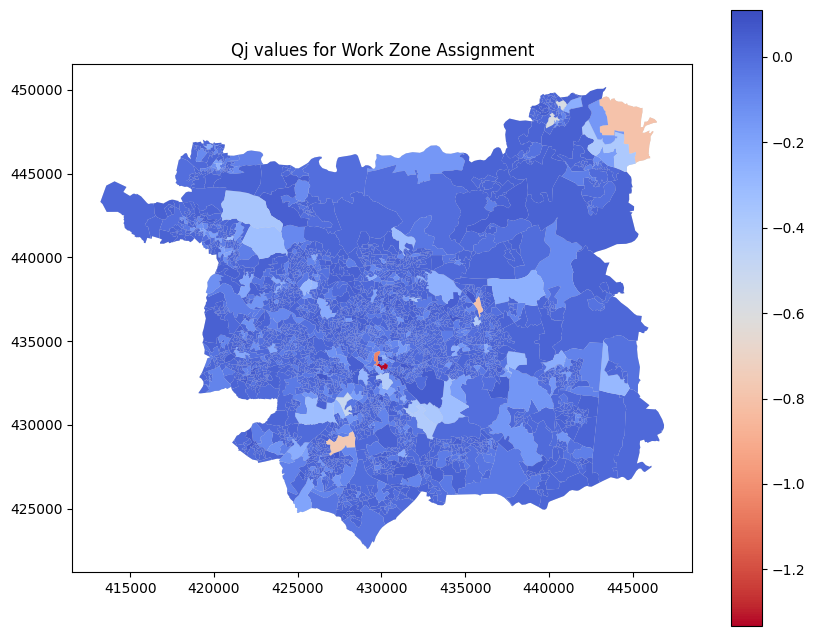

In [75]:
# Plot the map
fig, ax = plt.subplots(figsize=(10, 8))
boundaries.plot(ax=ax, color='lightgrey')
workzone_assignment_opt_agg_gdf.plot(column='qj', legend=True, cmap='coolwarm_r', ax=ax)

plt.title('Qj values for Work Zone Assignment')
plt.show()


In [62]:
# check if the layer is a gdf
type(workzone_assignment_opt_agg_gdf)





pandas.core.frame.DataFrame

### Fill in missing zones

Some activities are not assigned a zone because there is no zone that (a) has the activity, and (b) is reachable using the reported mode and duration (based on travel_time matrix r5 calculations). For these rows, we fill the zone using times based on euclidian distance and estimated speeds



In [ ]:
# Create a mask for rows where 'dzone' is NaN
mask = activity_chains_edu['dzone'] == 'NA'

# Apply the function to these rows and assign the result back to 'dzone'
activity_chains_edu.loc[mask, 'dzone'] = activity_chains_edu.loc[mask].apply(
    lambda row: fill_missing_zones(
        activity=row,
        travel_times_est=travel_time_estimates,
        activities_per_zone=activities_per_zone,
        activity_col="education_type",
    ),
    axis=1
)

In [ ]:
# Total rows and number of rows with NA in dzone
print(f"Total rows: {activity_chains_edu.shape[0]}")
print(f"Number of rows with NA in dzone: {activity_chains_edu[activity_chains_edu['dzone'] == 'NA'].shape[0]}")


 ### Assign activity to point locations

After choosing a zone, let's assign the activity to a point location. 

In [ ]:

# turn the above into a function
def select_activity(row: pd.Series,
                    activities_pts: gpd.GeoDataFrame,
                    sample_col: str = 'none',
                    ) -> pd.Series:
    """
    Select a suitable location for an activity based on the activity purpose and a specific zone

    Parameters
    ----------
    row : pandas.Series
        A row from the activity_chains DataFrame
    activities_pts : geopandas.GeoDataFrame
        A GeoDataFrame containing the activities to sample from
    sample_col : str, optional
        The column to sample from, by default 'none'.Options are: "floor_area", "none"


    Returns
    -------
    activity_id : int
        The id of the chosen activity
    activity_geom : shapely.geometry
        The geometry of the chosen activity

    """
    destination_zone = row['dzone']

    if destination_zone == 'NA':
        # log the error
        logging.info(f"Destination zone is NA for row {row}")
        return pd.Series([np.nan, np.nan])

    # filter to activities in the dsired zone
    activities_in_zone = activities_pts[activities_pts['OA21CD'] == destination_zone]

    if activities_in_zone.empty:
        logging.info(f"No activities in zone {destination_zone}")
        return pd.Series([np.nan, np.nan])


    # filter all rows in activities_in_zone where  activities includes the specific activity type
    activities_valid = activities_in_zone[activities_in_zone['activities'].apply(lambda x: row['education_type'] in x)]
    # if no activities match the exact education type, relax the constraint to just "education"
    if activities_valid.empty:
        logging.info(f"No activities in zone {destination_zone} with education type {row['education_type']},\
                      Returning activities with education type 'education'")
        activities_valid = activities_in_zone[activities_in_zone['activities'].apply(lambda x: 'education' in x)]
        # if still no activities match the education type, return NA
        if activities_valid.empty:
            logging.info(f"No activities in zone {destination_zone} with education type 'education'")
            return pd.Series([np.nan, np.nan])

    if sample_col == "floor_area":
        # sample an activity from activities_valid based on the floor_area column
        if activities_valid["floor_area"].sum() != 0:
            activity = activities_valid.sample(1, weights=activities_valid['floor_area'])
        else:
            activity = activities_valid.sample(1)
    else:
        activity = activities_valid.sample(1)

    return pd.Series([activity['id'].values[0], activity['geometry'].values[0]])


##### Maps

##### Bar Plots